# INSO Company Overview

To give an overview of the current companies, 

In [38]:
from sqlalchemy import create_engine
import pandas as pd
import os
from dotenv import load_dotenv 

# Load environment variables from `{root_dir}/.env` file
load_dotenv('../.env')

# Define your database connection parameters
server = os.getenv('SERVER_NAME')  # e.g., 'localhost', '192.168.1.1', or 'your_server.database.windows.net'
database = os.getenv('DATABASE_NAME')
username = os.getenv('USER_ADMIN')
password = os.getenv('PWD_ADMIN')
driver = 'ODBC Driver 17 for SQL Server'  # Make sure the driver is installed on your system

# Create the connection string
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver.replace(' ', '+')}"


# Connect to the database
try:
    conn = create_engine(connection_string)
    print("Connection successful!")

    # Use pandas to execute the SQL query
    query = f"""
        SELECT CompanyKeyCapitalIQ, CompanyKeyPitchbook, CompanyName, Country,
            LastFinancingDealType2, LastFinancingDate, Revenue,
            Sofina_Sector_ML_estimate AS Sofina_Sector, Sofina_Priority
        FROM PowerApps.LastCompanyEnriched
    """

    df_inso = pd.read_sql_query(query, conn)

except Exception as e:
    print("Error:", e)

Connection successful!


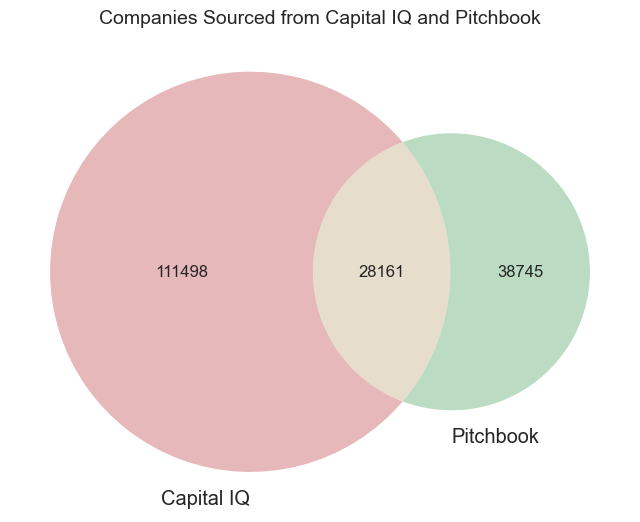

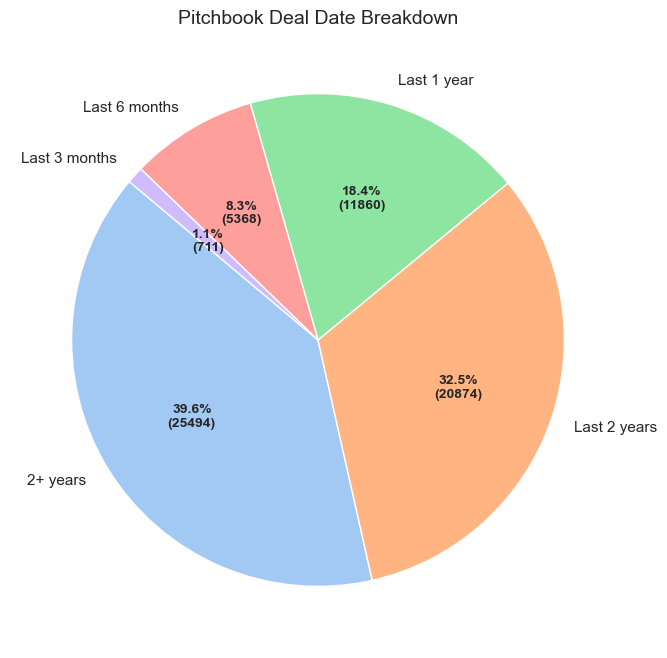

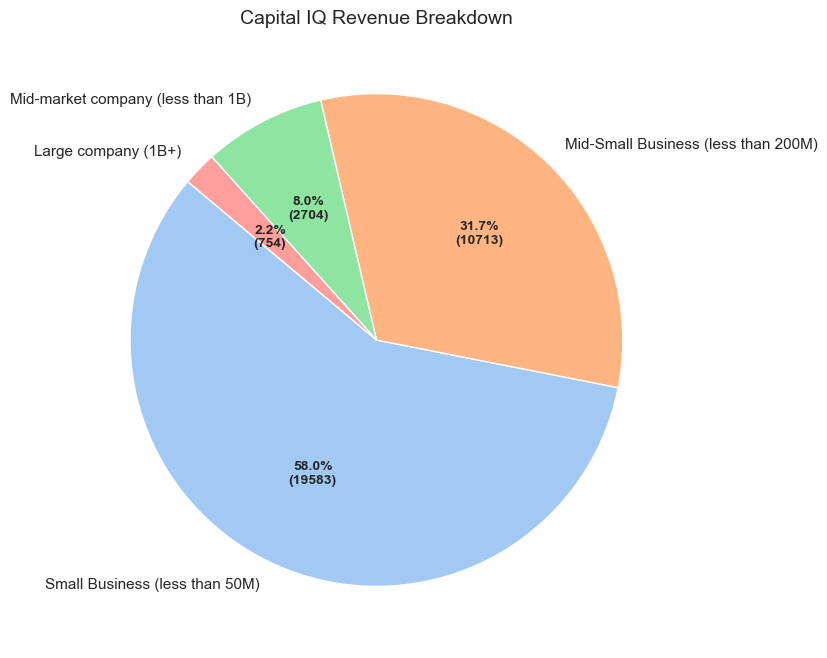

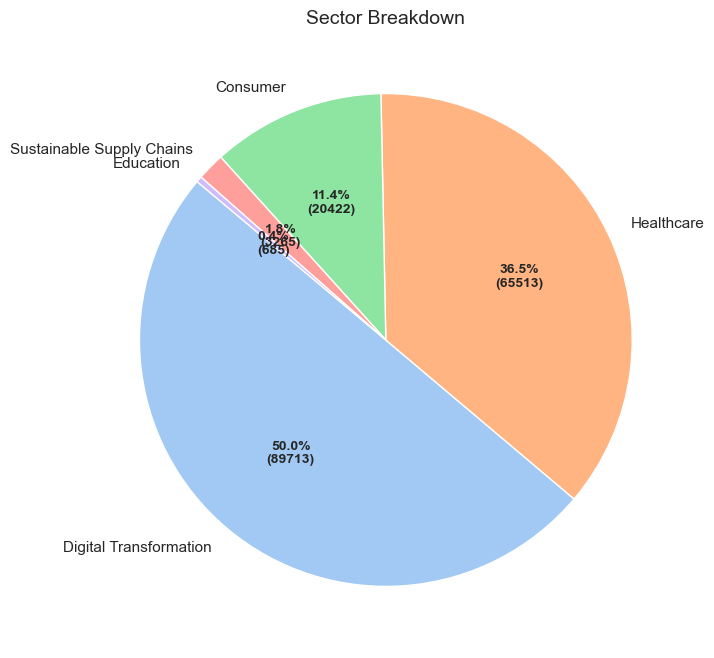

In [51]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

# Data Preparation
df_inso.replace('', pd.NA, inplace=True)
df_inso["LastFinancingDate"] = pd.to_datetime(df_inso["LastFinancingDate"])
current_date = pd.Timestamp.now()

# Pitchbook Breakdown
df_inso["Pitchbook_Breakdown"] = pd.cut(
    (current_date - df_inso["LastFinancingDate"]).dt.days,
    bins=[0, 90, 180, 365, 730, float("inf")],
    labels=["Last 3 months", "Last 6 months", "Last 1 year", "Last 2 years", "2+ years"]
)

# Capital IQ Breakdown
def revenue_category(revenue):
    if pd.isna(revenue):
        return None
    if revenue <= 50:
        return "Small Business (less than 50M)"
    elif revenue <= 200:
        return "Mid-Small Business (less than 200M)"
    elif revenue <= 1000:
        return "Mid-market company (less than 1B)"
    else:
        return "Large company (1B+)"

df_inso["Revenue_Breakdown"] = df_inso["Revenue"].apply(revenue_category)
df_inso["Sofina_Sector"] = df_inso["Sofina_Sector"].str.replace('Consumer / Retail', 'Consumer')

# Visualization
pitchbook_data = df_inso[df_inso["CompanyKeyPitchbook"].notna()]["Pitchbook_Breakdown"].value_counts()
capitaliq_data = df_inso[df_inso["CompanyKeyCapitalIQ"].notna()]["Revenue_Breakdown"].value_counts()

# Sector Breakdown
sector_data = df_inso["Sofina_Sector"].value_counts()


# Determine sets for Venn diagram
capitaliq_set = set(df_inso[df_inso["CompanyKeyCapitalIQ"].notna()]["CompanyName"])
pitchbook_set = set(df_inso[df_inso["CompanyKeyPitchbook"].notna()]["CompanyName"])
# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn = venn2([capitaliq_set, pitchbook_set], ('Capital IQ', 'Pitchbook'))
# Add title
plt.title("Companies Sourced from Capital IQ and Pitchbook", fontsize=14)
plt.show()

# Prepare a consistent theme for seaborn
sns.set_theme(style="whitegrid")

# Helper function to plot pie chart with exact values and percentages using seaborn
def plot_pie_with_values(data, title, figsize=(8, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax.pie(
        data.values,
        labels=data.index,
        autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*data.sum())})",
        startangle=140,
        colors=sns.color_palette("pastel")[0:len(data)],
    )
    ax.set_title(title, fontsize=14)
    plt.setp(autotexts, size=10, weight="bold")
    plt.show()

# Plot Pitchbook Deal Date Breakdown with values
plot_pie_with_values(pitchbook_data, "Pitchbook Deal Date Breakdown")

# Plot Capital IQ Revenue Breakdown with values
plot_pie_with_values(capitaliq_data, "Capital IQ Revenue Breakdown")

# Plot Sector Breakdown with values
plot_pie_with_values(sector_data, "Sector Breakdown")